(128, 128, 4467)


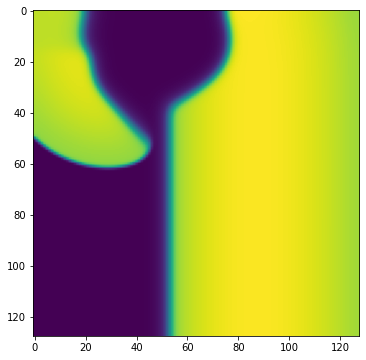

In [1]:
import numpy as np

from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

#import h5py
#with h5py.File('Vm_Model.mat', 'r') as mat:
#    V = np.array(mat['V'])
import scipy.io
f = scipy.io.loadmat('Vm_Model.mat')
V = f['Vm']

dx = 1; dy = dx; dt = 2e-3

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(V[:, :, 0])
print(V.shape)

In [2]:
Vobs = Observable('V', 0)
observables = [Vobs]

### define all parameters and "make library"
terms = generate_terms_to(3, observables=observables, max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(V.shape)
m = 12
qmax = 1
nweights = qmax**4
ndomains = 30 #250
wx = 64
wt = 50
pad = 0


In [3]:
%%prun

# fix random seed
np.random.seed(1)

data_dict = {'V': V}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=False)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=False)#, by_parts=False)

         142216 function calls (134084 primitive calls) in 5.086 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1260    1.591    0.001    1.648    0.001 function_base.py:4129(trapz)
        2    1.276    0.638    4.294    2.147 process_library_terms.py:257(make_library)
      450    0.529    0.001    1.354    0.003 process_library_terms.py:166(eval_term)
     4521    0.382    0.000    0.382    0.000 {method 'reduce' of 'numpy.ufunc' objects}
11104/5298    0.342    0.000    2.698    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.233    0.233    0.432    0.432 _methods.py:195(_var)
      450    0.231    0.001    0.653    0.001 process_library_terms.py:36(get_weight_array)
        1    0.188    0.188    0.783    0.783 process_library_terms.py:321(find_scales)
     1350    0.079    0.000    0.082    0.000 polynomial.py:664(polyval)
        1    0.050    0.050    0.482    0.482

In [4]:
from identify_models import *

opts = dict()
opts['threshold'] = "'threshold'"
opts['gamma'] = 2
opts['verbose'] = False
opts['brute_force'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#opts['n_terms'] = 3
opts1 = opts.copy()
opts1['char_sizes'] = char_sizes1
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([Q0, Q1], [opts, opts1], [terms0, terms1],
                                                        observables, threshold=1e-5)

#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 7.50e-09)
#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 2.08e-08)

[1. 0.]
[ 0.          1.          0.         -0.93197098]
[ 0.         -0.18027355  1.          0.          0.          0.37797466
  0.         -0.18907409]
[-0.54793242 -0.          1.        ]


In [8]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
p 3.0301881069336614
dj^2 p 0.0005897077441099261
dt p 0.009435323905758818
dt^2 p 3.685673400687038e-05
p * p 9.182039963402206
p * dt p 0.02859080628429723
p * p * p 27.823308294490953
dj u_j 0.02158255447274597
dt dj u_j 8.430685340916395e-05
dj p * u_j 0.06490194419228748
p * dj u_j 0.06539919988056274
u_j * u_j 2.9572075294167512
u_j * dt u_j 0.00927862784513299
p * u_j * u_j 8.960895085373314
di p 0.03774129562303527
dt di p 0.00014742693602748152
p * di p 0.11436322513718893
u_i 1.719653316635871
di dj u_j 0.0003372274136366558
dj^2 u_i 0.0003372274136366558
dt u_i 0.005395638618186493
dt^2 u_i 2.1076713352290987e-05
p * u_i 5.210873028119042
dt p * u_i 0.01622548604807187
p * dt u_i 0.016349799970140685
p * p * u_i 15.789925476547714
u_i * dj u_j 0.03711451138053196
u_j * di u_j 0.03711451138053196
u_j * dj u_i 0.03711451138053196
u_i * u_j * u_j 5.085371735942086
